# Test Setup for Transient Analysis

In [2]:
from CircuitCalculator.Circuit.solution import DCSolution
from CircuitCalculator.Circuit.circuit import Circuit, transform_circuit
from CircuitCalculator.Circuit import components as cmp
from CircuitCalculator.Network import elements as elm
from CircuitCalculator.Network.network import Network, Branch

In [3]:
G1, G2, G3 = 10, 20, 30
R1, R2, R3 = 1/G1, 1/G2, 1/G3
R1, R2, R3 = 10, 20, 30
G1, G2, G3 = 1/R1, 1/R2, 1/R3
RC = 40e6
C = 1e-3
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=1, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.resistor(id='R2', R=R2, nodes=('2', '0')),
    cmp.resistor(id='R3', R=R3, nodes=('2', '3')),
    cmp.capacitor(id='C', C=C, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])
solution = DCSolution(circuit)

In [4]:
network = transform_circuit(circuit, w=0)
network = Network([
    Branch(node1='1', node2='0', element=elm.NortenElement(name='Uq', type='voltage_source', Z=0, V=1)),
    Branch(node1='1', node2='2', element=elm.NortenElement(name='R1', type='resistor', Z=R1, V=0)),
    Branch(node1='2', node2='0', element=elm.NortenElement(name='R2', type='resistor', Z=R2, V=0)),
    Branch(node1='2', node2='3', element=elm.NortenElement(name='R3', type='resistor', Z=R3, V=0)),
    Branch(node1='3', node2='0', element=elm.TheveninElement(name='C', type='capacitor', Y=1/RC, I=0))
])

## Funktion zur Berechnung der State Space Matrizen

In [5]:
from CircuitCalculator.Network.NodalAnalysis.state_space_model import NodalStateSpaceModel, BranchValues
ss = NodalStateSpaceModel(network=network, c_values=[BranchValues(value=C, node1='3', node2='0')])

In [6]:
from scipy import signal
import numpy as np

ssC = np.array([[1-R3*(R1+R2)/(R1*R2+R2*R3+R1*R3)], [1]])
ssD = np.array([[R2*R3/(R1*R2+R2*R3+R1*R3)], [0]])

sys = signal.StateSpace(ss.A, ss.B, ss.C, ss.D)


In [7]:
t = np.arange(0, 0.3, 0.0003)
U = t > 0.1

tout, yout, xout = signal.lsim(sys, U, t)

In [8]:
def pll(R1, R2):
    return R1*R2/(R1+R2)

Ri = pll(pll(R1, R2)+R3, RC)
tau = Ri*C
u_ref = U*RC/(RC+R3)*pll(R2, R3+RC)/(R1+pll(R2, R3+RC))*(1-np.exp(-(tout-0.1)/tau))

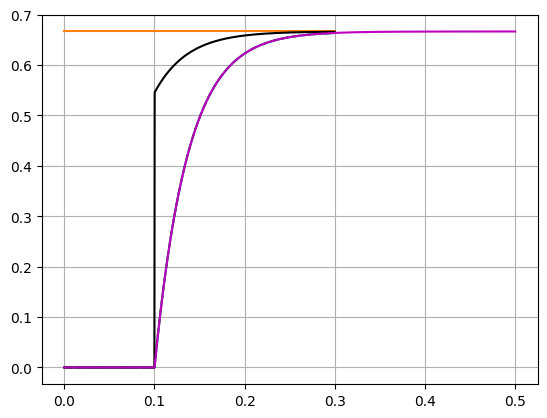

In [10]:
import matplotlib.pyplot as plt

plt.plot(tout, yout[:,1])
plt.plot((tout[0], tout[-1]), (solution.get_voltage('C'), solution.get_voltage('C')))
plt.plot(tout, u_ref, 'g--')
plt.plot(tout, yout[:,0], 'k')
plt.grid(True)

from CircuitCalculator.Network.NodalAnalysis.transient_analysis import NodalStateSpaceModel
from CircuitCalculator.Network.NodalAnalysis.transient_analysis import TransientAnalysisSolution
from CircuitCalculator.Network.NodalAnalysis.state_space_model import BranchValues
from CircuitCalculator.SignalProcessing.one_sided_functions import step
from CircuitCalculator.Network.network import Network, Branch
from CircuitCalculator.Network.elements import voltage_source, open_circuit, resistor
import functools
import numpy as np
solution = TransientAnalysisSolution(network, c_values=[BranchValues(C, '3', '0')], input={'Uq': functools.partial(step, t0=0.1)}, t_lim=(0, 0.5), Ts=0.0003)
t, u = solution.get_voltage('C')
plt.plot(t, u, 'm')
